<a href="https://colab.research.google.com/github/Gaussiandra/bdimo21/blob/main/new15_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# reg
# 0 как таргеты
# балансировка
# больше агригаций

In [1]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26124         614       23489           0        2021       25152
Swap:             0           0           0


In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5090aae0-7224-5e3c-e7dd-a86ef96b7c42)


In [3]:
!pip install catboost

     |████████████████████████████████| 65.7MB 43kB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import numpy as np
import lightgbm
from sklearn.model_selection import train_test_split
import joblib
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier
from sklearn.pipeline import make_pipeline
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import seaborn as sns
from tqdm.auto import tqdm
sns.set()

In [3]:
sys.path.append('/content/drive/MyDrive/ML/bdimo21/')

In [4]:
import submission
import importlib
importlib.reload(submission)

<module 'submission' from '/content/drive/MyDrive/ML/bdimo21/submission.py'>

In [5]:
import catboost

In [6]:
global_path = '/content/drive/MyDrive/ML/bdimo21/'

In [7]:
rheed_long = pd.read_csv(global_path+"ONTI_Dataset_parsed.csv", parse_dates=[6])
ma_coolness = rheed_long['Coolness_RHEED'].rolling(50).mean()
rheed_long['target'] = abs(ma_coolness-ma_coolness.shift(-435))

In [8]:
df = submission.preprocess(rheed_long, is_train=True)

In [9]:
df.columns.tolist()

['Coolness_RHEED',
 'R FWHM_RHEED',
 'X FWHM_RHEED',
 'Y FWHM_RHEED',
 'Filtered Rate',
 'Raw Rate',
 'Source Power',
 'Crystal Position',
 'Fundamental Freq',
 'Speed_RHEED',
 'Length_RHEED',
 'Speed',
 'Coolness_RHEED_mean_75',
 'Coolness_RHEED_std_75',
 'Coolness_RHEED_median_75',
 'Coolness_RHEED_min_75',
 'Coolness_RHEED_max_75',
 'R FWHM_RHEED_mean_75',
 'R FWHM_RHEED_std_75',
 'R FWHM_RHEED_median_75',
 'R FWHM_RHEED_min_75',
 'R FWHM_RHEED_max_75',
 'X FWHM_RHEED_mean_75',
 'X FWHM_RHEED_std_75',
 'X FWHM_RHEED_median_75',
 'X FWHM_RHEED_min_75',
 'X FWHM_RHEED_max_75',
 'Y FWHM_RHEED_mean_75',
 'Y FWHM_RHEED_std_75',
 'Y FWHM_RHEED_median_75',
 'Y FWHM_RHEED_min_75',
 'Y FWHM_RHEED_max_75',
 'Filtered Rate_mean_75',
 'Filtered Rate_std_75',
 'Raw Rate_mean_75',
 'Raw Rate_std_75',
 'Source Power_mean_75',
 'Source Power_std_75',
 'Crystal Position_mean_75',
 'Crystal Position_std_75',
 'Fundamental Freq_mean_75',
 'Fundamental Freq_std_75',
 'Speed_RHEED_mean_75',
 'Speed_RHEE

In [10]:
X = df.iloc[:-435]
y = rheed_long['target'].iloc[3000:-435]

In [11]:
X.shape, y.shape

((2360337, 238), (2360337,))

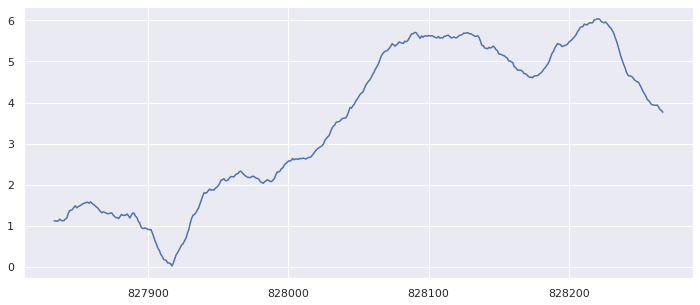

In [39]:
plt.figure(figsize=(12, 5))
st = np.random.randint(0, 10e5, (1,)).reshape(-1)[0]
y[st:st+435].plot()

In [13]:
correlations = df.apply(lambda x: x.corr(y))

In [17]:
correlations.abs().sort_values()[-50:]

roll_mean_1505                0.236067
R FWHM_RHEED_std_1200         0.241575
Coolness_RHEED_median_3000    0.244210
X FWHM_RHEED_min_500          0.245272
Y FWHM_RHEED_min_50           0.246120
Coolness_RHEED_median_4000    0.246413
Coolness_RHEED_mean_2000      0.246836
roll_mean_2005                0.246951
X FWHM_RHEED_min_425          0.247457
X FWHM_RHEED_min_100          0.249681
R FWHM_RHEED_min_100          0.250497
Y FWHM_RHEED_min_500          0.252488
R FWHM_RHEED_min_500          0.252712
X FWHM_RHEED_min_250          0.253998
R FWHM_RHEED_min_425          0.254747
Y FWHM_RHEED_min_425          0.254917
roll_mean_2505                0.255662
R FWHM_RHEED_min_250          0.259484
Length_RHEED_std_4000         0.260369
Coolness_RHEED_mean_3000      0.260999
roll_mean_3005                0.261040
Y FWHM_RHEED_min_100          0.261307
Y FWHM_RHEED_min_250          0.263137
roll_mean_3505                0.263494
Coolness_RHEED_mean_4000      0.264074
Coolness_RHEED_min_500   

In [16]:
#y[ma_coolness.shift(-435) == 0] = 1

In [17]:
y

3500       10.612
3501       10.554
3502       10.496
3503       10.422
3504       10.364
            ...  
2363332     0.000
2363333     0.000
2363334     0.000
2363335     0.000
2363336     0.000
Name: target, Length: 2359837, dtype: float64

In [18]:
sample_probas = softmax(y)

In [19]:
y_sampled = y.sample(1250000, weights=sample_probas, random_state=1234)

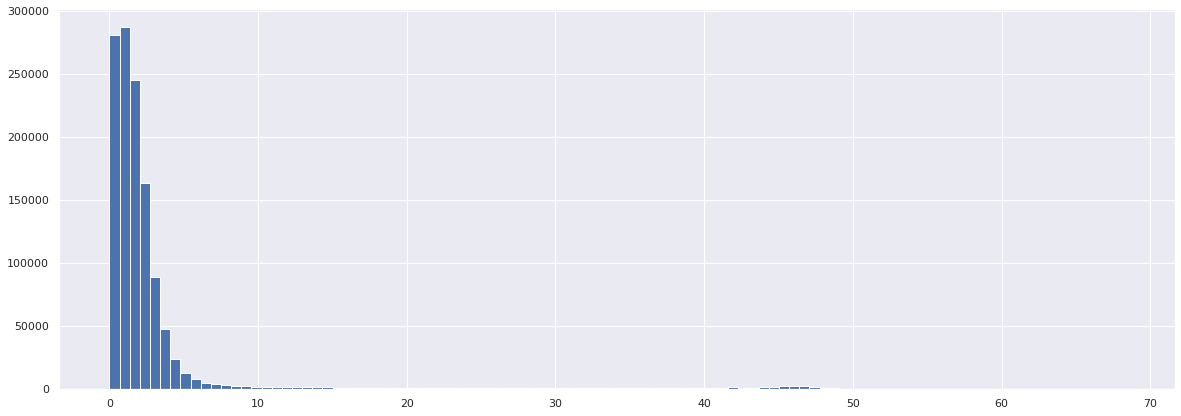

In [20]:
plt.figure(figsize=(20, 7))
y_sampled.hist(bins=100)

In [21]:
(y_sampled < 5).sum()

1143922

In [15]:
# ratio = 5
# y_sampled = pd.concat((y[y==0].sample(y.value_counts()[1]*ratio, replace=False, random_state=0),
#                        y[y==1]), axis=0)
# X_sampled = X.loc[y_sampled.index]

#X_train, X_val, y_train, y_val = train_test_split(X_sampled, y_sampled, test_size=0.25, shuffle=True, stratify=y_sampled, random_state=0)
model = catboost.CatBoostRegressor(
    iterations=350,
    #task_type="GPU",
    #eval_metric='AUC',
    verbose=50
)
model.fit(X, y)#, eval_set=(X_val, y_val))

Learning rate set to 0.345381
0:	learn: 5.0416775	total: 560ms	remaining: 3m 15s
50:	learn: 2.7015042	total: 35.7s	remaining: 3m 29s
100:	learn: 2.0318865	total: 1m 12s	remaining: 2m 58s
150:	learn: 1.7023259	total: 1m 49s	remaining: 2m 24s
200:	learn: 1.5111623	total: 2m 27s	remaining: 1m 49s
250:	learn: 1.3809914	total: 3m 5s	remaining: 1m 13s
300:	learn: 1.2928073	total: 3m 43s	remaining: 36.4s
349:	learn: 1.2131546	total: 4m 23s	remaining: 0us


In [16]:
with open(global_path+'model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open(global_path+'model.pkl', 'rb') as f:
    model = pickle.load(f)

In [17]:
model.get_feature_importance(prettified=True)[:50]#['Feature Id'].values.tolist().index('Coolness_RHEED_3500')

,Feature Id,Importances
0,Length_RHEED_max_1500,4.027300
1,Length_RHEED_mean_3000,3.553572
2,Length_RHEED_mean_75_back_75,3.387760
3,Coolness_RHEED_std_500,2.855862
4,Coolness_RHEED_median_75,2.548180
5,X FWHM_RHEED_mean_75,2.427145
6,Coolness_RHEED_std_75,2.291763
7,Length_RHEED_max_3000,2.230936
8,Fundamental Freq_mean_3000,1.761461
9,Crystal Position_mean_3000,1.654401


In [ ]:
trans = lambda x: 1 / (1 + np.exp(-x + 5))
plt.plot(np.linspace(0, 10, 1000), trans(np.linspace(0, 10, 1000)))

In [ ]:
sklearn.metrics.plot_confusion_matrix(model, X_train, y_train, normalize='all')  # doctest: +SKIP
plt.show()  # doctest: +SKIP

In [ ]:
sklearn.metrics.plot_confusion_matrix(model, X_val, y_val,normalize='all')  # doctest: +SKIP
plt.show()  # doctest: +SKIP

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_val, model.predict_proba(X_val)[:,1])
roc_auc = sklearn.metrics.roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_train, model.predict_proba(X_train)[:,1])
roc_auc = sklearn.metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.get_feature_importance(prettified=True)[:50]

In [23]:
pr = submission.Predictor()

In [25]:
pr.forecast(rheed_long.iloc[-9000:])

0.9999999999999958